In [1]:
# jupyter extension that allows reloading functions from imports without clearing kernel :D
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
import dlib
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import numpy as np

In [3]:
# from utils import draw_face
# from utils import draw_landmarks
# from utils import draw_triangulation
# from utils import get_triangles
# from utils import extract_face

from utils import better_plotter
from utils import get_landmark_coords

In [4]:
# Initialize the face detector and facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('predictor/shape_predictor_68_face_landmarks.dat')

In [5]:
# Load the image
source_img = cv2.imread('images/vermeer.jpg')
target_img = cv2.imread('images/american-gothic.jpg')

## Extracting facial feature points

In [6]:
# Convert the image to grayscale
source_img_gray = cv2.cvtColor(source_img, cv2.COLOR_BGR2GRAY)
target_img_gray = cv2.cvtColor(target_img, cv2.COLOR_BGR2GRAY)

# Detect faces in the image
source_faces = detector(source_img_gray)
target_faces = detector(target_img_gray)

print("number of faces in [source] is", len(source_faces))
print("number of faces in [traget] is", len(target_faces))

number of faces in [source] is 1
number of faces in [traget] is 2


source face coordinates: (463, 701) (998, 1236)
target face coordinates: (112, 211) (261, 360)


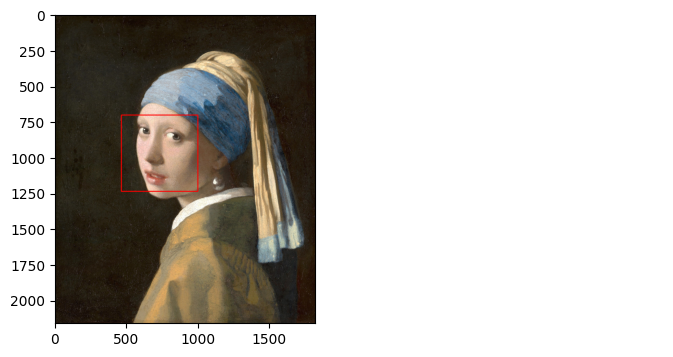

In [7]:
print(
    "source face coordinates:",
    (source_faces[0].left(), source_faces[0].top()), 
    (source_faces[0].right(), source_faces[0].bottom())
)

print(
    "target face coordinates:",
    (target_faces[0].left(), target_faces[0].top()), 
    (target_faces[0].right(), target_faces[0].bottom())
)

image_with_source_face = cv2.cvtColor(source_img.copy(), cv2.COLOR_BGR2RGB)
cv2.rectangle(
    image_with_source_face, 
    (source_faces[0].left(), source_faces[0].top()), 
    (source_faces[0].right(), source_faces[0].bottom()),
    (255, 0, 0), 
    5
)

better_plotter([
    {
        "img": image_with_source_face,
        "title": ""
    }
], plot_size=(8, 4))

In [16]:
faces = source_faces # source_faces
image_gray = source_img_gray # source_img_gray
image = source_img # source_img

68
number of triangles 113


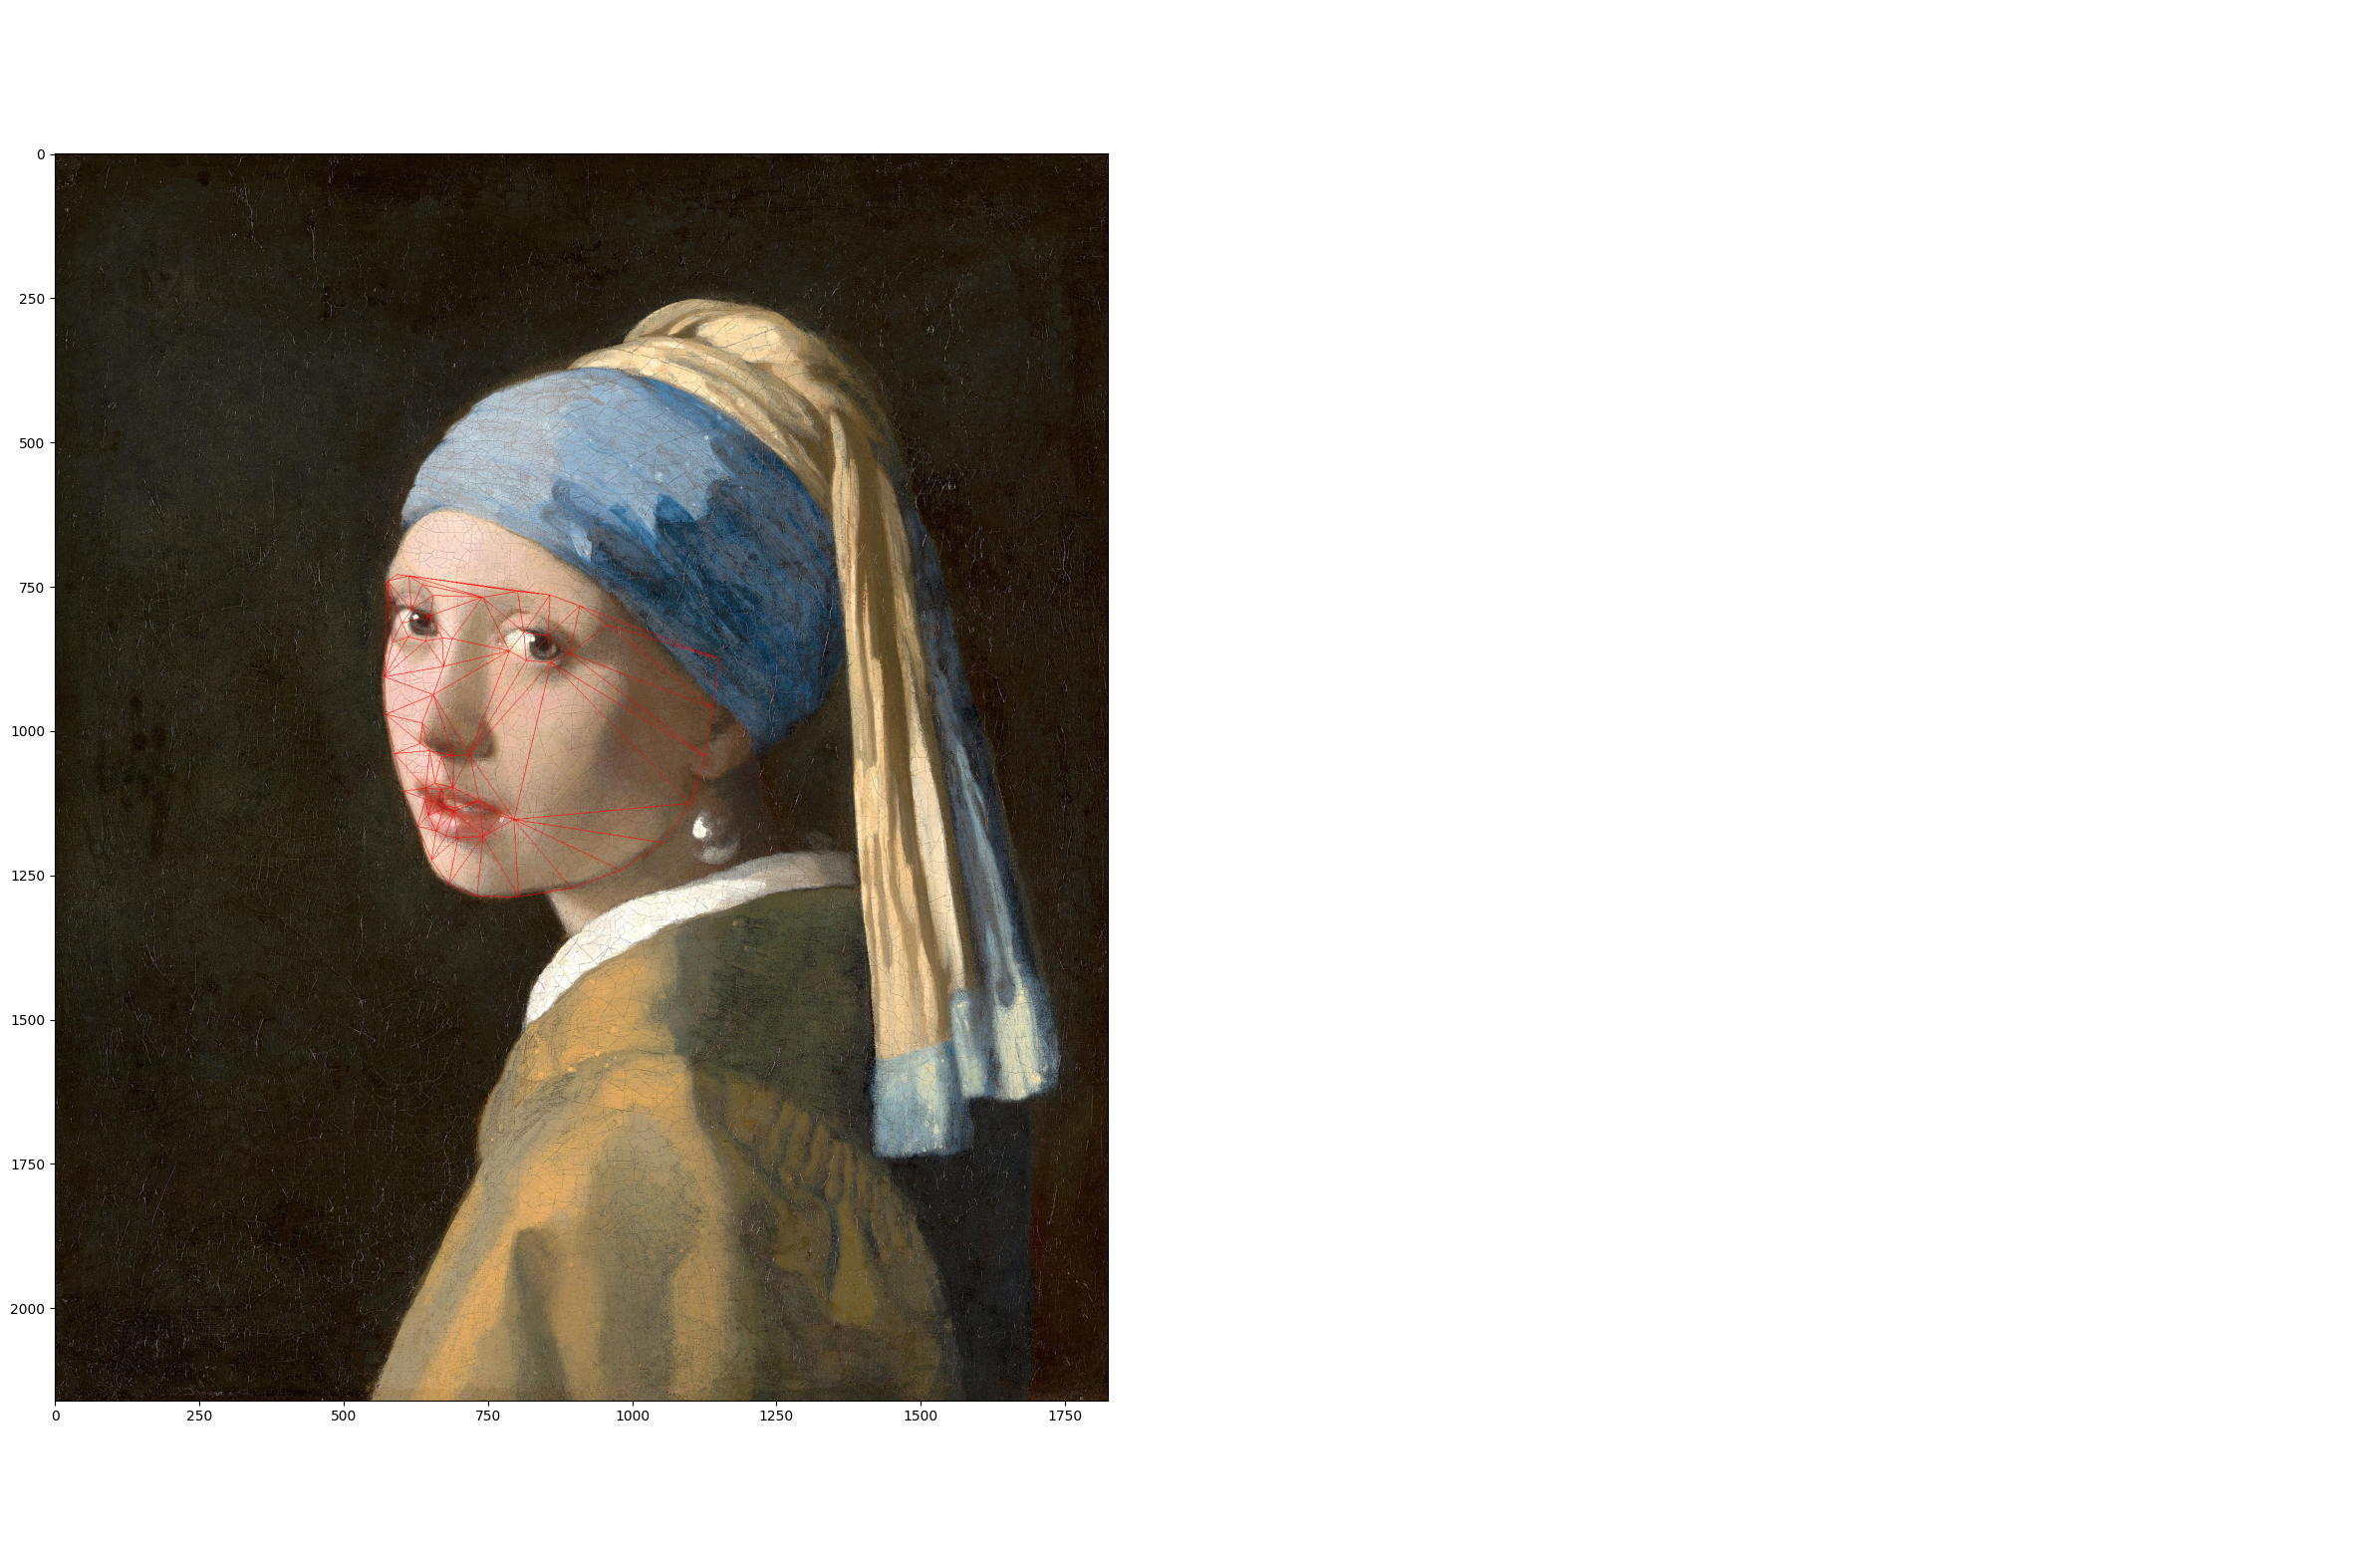

In [17]:
image_triangulation = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)

# Function to get coordinates from landmarks
def get_landmark_coords(landmarks):
    coords = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(0, 68)])
    return coords

# Get landmarks and perform Delaunay triangulation on the first face as a reference
if faces:
    reference_landmarks = predictor(image_gray, faces[0])
    reference_coords = get_landmark_coords(reference_landmarks)
    tri = Delaunay(reference_coords)

# Apply triangulation to each face
for face in faces:
    landmarks = predictor(image_gray, face)
    coords = get_landmark_coords(landmarks)

    print(len(coords))

    triangle_counts = 0
    # Draw triangles
    for triangle in tri.simplices:
        pt1 = tuple(coords[triangle[0]])
        pt2 = tuple(coords[triangle[1]])
        pt3 = tuple(coords[triangle[2]])

        cv2.line(image_triangulation, pt1, pt2, (255, 0, 0), 1)
        cv2.line(image_triangulation, pt2, pt3, (255, 0, 0), 1)
        cv2.line(image_triangulation, pt3, pt1, (255, 0, 0), 1)
        triangle_counts += 1

    print("number of triangles", triangle_counts)

better_plotter([
    {
        "img": image_triangulation,
        "title": ""
    }
], plot_size=(30, 20))